In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
import scipy.io

np.random.seed(2345)
torch.manual_seed(1234)
# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")
    
torch.backends.cudnn.benchmark = True
epsilon = torch.finfo(torch.float32).eps

CUDA is available


In [2]:
class ConvAutoencoder(torch.nn.Module):
    def __init__(self, channels=[2, 16, 32, 64, 128]):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        encoder_layers = []
        for i in range(len(channels) - 1):
            encoder_layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=2, padding=1))
            encoder_layers.append(nn.Tanh())
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []
        for i in range(len(channels) - 1, 0, -1):
            decoder_layers.append(nn.ConvTranspose2d(channels[i], channels[i-1], kernel_size=3, stride=2, padding=1, output_padding=1))
            decoder_layers.append(nn.Tanh())
        self.decoder = nn.Sequential(*decoder_layers)

        # smoother layers
        self.smoother1 = nn.Conv2d(2, 16, kernel_size=7, padding=3, stride=1)
        self.smoother2 = nn.Conv2d(16, 2, kernel_size=7, padding=3, stride=1)
        self.a = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        # Encoding
        x_encoded = self.encoder(x)
        # Decoding
        x_decoded = self.decoder(x_encoded)
        # smoothing
        x = self.smoother1(x_decoded)
        x = torch.tanh(x)
        x = 5 * self.a * x
        x = self.smoother2(x)
        return x

In [24]:
class PhysicsInformedNN1:
    def __init__(self, ref_gray_matrix, def_gray_matrix, ROI, channels , IX, IY):
        self.Iref = torch.tensor(ref_gray_matrix, dtype=torch.float32).to(device)
        self.Idef = torch.tensor(def_gray_matrix, dtype=torch.float32).to(device)
        self.roi = torch.tensor(ROI, dtype=torch.float32).to(device)
        self.ROI = ROI
        self.IX = torch.tensor(IX, dtype=torch.float32).to(device)
        self.IY = torch.tensor(IY, dtype=torch.float32).to(device)
        self.XY = torch.stack((self.IX, self.IY), dim=2).unsqueeze(0)
        self.DXY = torch.stack((self.Iref, self.Idef), dim=2).unsqueeze(0)/128-1
        self.channels_configuration  = channels
        # 误差图汉明窗设置
        self.window_size = 3 # 汉明窗大小为奇数
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = True # true：采用二维汉明窗，false：采用一维汉明窗
        # 控制点设置
        self.Dis_beta = 1
        self.u_sample = 0
        self.v_sample = 0
        self.cp_flag = False # true：采用位移控制点，false：不采用
        # 加载深度学习网络
        self.dnn = ConvAutoencoder(channels=channels).to(device)
        
        self.epoch = 0
        self.loss_temp=100
        self.loss_list = []
        self.lossf_list = []
        
        # 设置优化器
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=1, max_iter=2000, max_eval=50000,
                                           history_size=100, tolerance_grad=1e-08, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.0005,  eps=1e-8, weight_decay=0.0001)
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer_adam, T_max=100)  # T_max 可以根据需要调整
 
    def smooth_hm(self, loss, twoD=False):
        matrix = loss
        if twoD == True:
            window_2d = self.window.outer(self.window)
            smoothed_matrix = F.conv2d(matrix.unsqueeze(0).unsqueeze(0), 
                                       window_2d.unsqueeze(0).unsqueeze(0), 
                                       padding=self.window_size // 2)
        else:
            window_1d = self.window
            smoothed_matrix = F.conv1d(matrix.view(1, 1, -1), 
                                       window_1d.view(1, 1, -1), 
                                       padding=self.window_size // 2)
            smoothed_matrix = smoothed_matrix.view(matrix.size())
        return smoothed_matrix
    
    def set_window(self, window_size, flag=False):
        self.window_size = window_size
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = flag

    def set_cp_dis(self, dis_u_sample, dis_v_sample, step_row, step_col, Dis_beta = 1, epoch_gap=100):
        self.step_row = step_row
        self.step_col = step_col
        self.u_sample = torch.tensor(dis_u_sample, dtype=torch.float32).to(device)
        self.v_sample = torch.tensor(dis_v_sample, dtype=torch.float32).to(device)
        self.Dis_beta = Dis_beta
        self.epoch_gap = epoch_gap
        self.cp_flag = True
        if self.cp_flag:
            print("Control point loss function activated")
            print(f"step_row:{self.step_row}, step_col:{self.step_col}")
            print(f"Dis_beta:{self.Dis_beta}, epoch_gap:{self.epoch_gap}")
        else:
            print("Control point loss function unactivated")

    def beta_update(self, loss_1, loss_2):
        if self.epoch % self.epoch_gap == 0:
            # 推断阶段，不需要计算梯度
            with torch.no_grad():
                a = torch.log10(loss_1)
                a = torch.round(a)
                b = torch.log10(loss_2)
                b = torch.round(b)
                beta = 10**(a-b-1)
                self.Dis_beta = beta
                print(f"Dis_beta:{self.Dis_beta}")
     
    def loss_fn1(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        loss_cp_dis = 0
        if self.cp_flag:
            u_s = UV[0,0][0::self.step_row, :][:, 0::self.step_col]
            v_s = UV[0,1][0::self.step_row, :][:, 0::self.step_col]
            L_cp_dis_u = (self.u_sample - u_s)**2
            L_cp_dis_v = (self.v_sample - v_s)**2
            L_cp_dis = L_cp_dis_u + L_cp_dis_v
            loss_cp_dis = torch.sum(L_cp_dis)/(L_cp_dis.shape[0]*L_cp_dis.shape[1])
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2
        abs_error = torch.log(1+abs_error) * self.roi
        # abs_error = self.smooth_hm(abs_error, self.twoD) * self.roi    # 加窗平滑
        abs_error = abs_error.view(self.Iref.size())
        loss_f = 5 * torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1])
        loss = loss_f + loss_cp_dis * self.Dis_beta
        loss.backward()
        self.epoch = self.epoch+1
        # self.beta_update(loss_f, loss_cp_dis)
        if self.epoch%100 == 1:
            if self.cp_flag:
                cp_dis_string = f", Loss_cp_Dis: {loss_cp_dis.item():.4e}"
            else:
                cp_dis_string = ""
            print(f"Epoch [{self.epoch}], Loss: {loss.item():.4f}, Loss_f: {loss_f.item():.4f}" + cp_dis_string)
            self.loss_list.append(loss.item())
        return loss

    def loss_fn2(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        loss_cp_dis = 0
        if self.cp_flag:
            u_s = UV[0,0][0::self.step_row, :][:, 0::self.step_col]
            v_s = UV[0,1][0::self.step_row, :][:, 0::self.step_col]
            L_cp_dis_u = (self.u_sample - u_s)**2
            L_cp_dis_v = (self.v_sample - v_s)**2
            L_cp_dis = L_cp_dis_u + L_cp_dis_v
            loss_cp_dis = torch.sum(L_cp_dis)/(L_cp_dis.shape[0]*L_cp_dis.shape[1])
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2 * self.roi
        # abs_error = self.smooth_hm(abs_error, self.twoD) * self.roi    # 加窗平滑
        abs_error = abs_error.view(self.Iref.size())
        loss_f = torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]) 
        loss = loss_f + loss_cp_dis * self.Dis_beta
        loss.backward()
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:  
            if self.cp_flag:
                cp_dis_string = f", Loss_cp_Dis: {loss_cp_dis.item():.4e}"
            else:
                cp_dis_string = ""
            print(f"Epoch [{self.epoch}], Loss: {loss.item():.4f}, Loss_f: {loss_f.item():.4f}" + cp_dis_string)
            self.loss_list.append(loss.item())
        return loss
    
    def save_model_parameter(self, loss):
        if loss.item() < 0.05:
            if loss.item() < self.loss_temp:
                self.loss_temp = loss.item()
                torch.save(self.dnn.state_dict(), f'model_checkpoint_epoch_{self.epoch}.pth')
                print(f"Model saved at epoch {self.epoch}, loss:{loss.item()}") 
         
    def train(self, flag):
        self.dnn.train()
        if flag==1:
            self.optimizer.step(self.loss_fn1)
        else:
            self.optimizer.step(self.loss_fn2)          
    
    def train_adam(self, flag, epoch):
        self.dnn.train()
        if flag==1:
            for iter in range(epoch):
                loss = self.loss_fn1()
                self.optimizer_adam.step()
                self.scheduler.step()
                #self.save_model_parameter(loss)
        else:
            for iter in range(epoch):
                loss = self.loss_fn2()
                self.optimizer_adam.step()
                self.scheduler.step()
                #self.save_model_parameter(loss)
    
    def predict(self, X, Y):
        self.dnn.eval()
        Ixy = np.stack((X, Y), axis=-1)
        Ixy = torch.tensor(Ixy, dtype=torch.float32).unsqueeze(0).to(device)
        U = self.dnn(Ixy)
        u = U[:,0]
        u = u.cpu().detach().numpy()
        v = U[:,1]
        v = v.cpu().detach().numpy()
        return u, v

In [4]:
def model_train(model, IX, IY, pretrain_epoch, train_epoch, pretrain_Lbfgs=0, train_Lbfgs=0, new_lr=0.0001):
    if pretrain_epoch != 0:
        model.train_adam(1, pretrain_epoch)
    if pretrain_Lbfgs == 1:
        model.train(1)
    print('****************over****************')
    u,v = model.predict(IX, IY)
    plt.figure(dpi=100)
    plt.subplot(2, 2, 1)
    plt.imshow(u[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Pre-train: u predicted")
    plt.subplot(2, 2, 2)
    plt.imshow(v[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Pre-train: v predicted")
    
    if train_epoch != 0:
        model.optimizer_adam.param_groups[0]['lr'] = new_lr
        model.train_adam(2, train_epoch)
    if train_Lbfgs == 1:
        model.train(2)
    u1,v1 = model.predict(IX, IY)
    plt.subplot(2, 2, 3)
    plt.imshow(u1[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: u predicted")
    plt.subplot(2, 2, 4)
    plt.imshow(v1[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: v predicted")

def result_plot(model ,IX, IY, u_min=0, u_max=1, v_min=0, v_max=1,string='',layout = [1,2]):
    u1,v1 = model.predict(IX, IY)
    plt.figure(figsize=(4*layout[0], 4*layout[1]), dpi=100)
    normu = matplotlib.colors.Normalize(vmin=u_min, vmax=u_max)
    normv = matplotlib.colors.Normalize(vmin=v_min, vmax=v_min)
    plt.subplot(layout[0], layout[1], 1)
    plt.imshow(u1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: u predicted"+string, fontsize=10)
    plt.subplot(layout[0], layout[1], 2)
    plt.imshow(v1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: v predicted"+string, fontsize=10)
    
def contourf_plot(model, IX, IY, N):
    u1,v1 = model.predict(IX, IY)
    u_sub1 = np.flip(u1[0], axis=0)
    v_sub1 = np.flip(v1[0], axis=0)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3), dpi=300)
    c1 = ax1.contourf(IX, IY, u_sub1, N, cmap='jet')
    ax1.axis('off')
    c2 = ax2.contourf(IX, IY, v_sub1, N, cmap='jet')
    ax2.axis('off')
    
def error_plot(model ,IX, IY, u=0, v=0, v_min=0, v_max=1, string='',layout = [1,2]):
    u1,v1 = model.predict(IX, IY)
    plt.figure(figsize=(4*layout[0], 4*layout[1]), dpi=100)
    norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    plt.subplot(layout[0], layout[1], 1)
    plt.imshow(np.abs(u1[0]-u), cmap='jet', interpolation='nearest', norm=norm)
    plt.colorbar()
    plt.axis('off')
    plt.title("Error of u"+string, fontsize=10)
    plt.subplot(layout[0], layout[1], 2)
    plt.imshow(np.abs(v1[0]-v), cmap='jet', interpolation='nearest', norm=norm)
    plt.colorbar()
    plt.axis('off')
    plt.title("Error of v"+string, fontsize=10)
    L_cp_dis_u = (u1[0]-u)**2
    L_cp_dis_v = (v1[0]-v)**2
    L_cp_dis = L_cp_dis_u + L_cp_dis_v
    loss_cp_dis = np.sum(L_cp_dis)/(L_cp_dis.shape[0]*L_cp_dis.shape[1])
    print(loss_cp_dis)
    
def sample_matrix(matrix, step_row=3, step_col=3, flag=0):
    rows, cols = matrix.shape
    sample_values = []
    sample_coordinates = []
    for i in range(0, rows, step_row):
        for j in range(0, cols, step_col):
            value = matrix[i, j]
            coordinate = (i, j)
            sample_values.append(value)
            sample_coordinates.append(coordinate)
    if flag == 0:        
        sample_values = np.array(sample_values)
        sample_coordinates = np.array(sample_coordinates)
        sample_values = sample_values.reshape(rows//step_row, cols//step_col)
    else:
        sample_values = torch.tensor(sample_values, dtype=torch.float32).to(device)
        # sample_coordinates = torch.tensor(sample_coordinates, dtype=torch.float32).to(device)
        sample_values = sample_values.view(rows//step_row, cols//step_col)
    return sample_values, sample_coordinates

def save_mat(model, IX, IY, u, v, save_file, N, step_row, step_col, flag=False):
    u1,v1 = model.predict(IX, IY)
    up = u1[0]
    vp = v1[0]
    error_u = up - u
    error_v = vp - v
    data_to_save = {'u': up, 'v': vp, 'eu': error_u, 'ev': error_v}
    if flag:
        string = f'/with cp/noise{N}'
        scipy.io.savemat(save_file+ string + f'/Star_N{N}_R{step_row}C{step_col}.mat', data_to_save)
    else:
        string = '/without cp'
        scipy.io.savemat(save_file+ string + f'/Star_N{N}.mat', data_to_save)

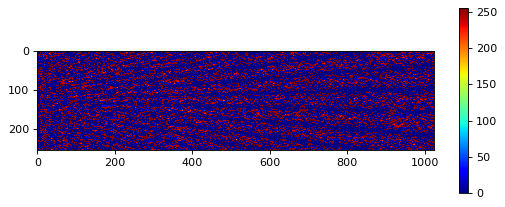

In [25]:
folder_directory = '../Data/Speckle_image/simulation_experiment/star_displacement'
save_file = 'Displacement plot star'
image_path_RG = os.path.join(folder_directory, 'Star_RG_256X1024_120_10.bmp')
ref_image = Image.open(image_path_RG)
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray

image_path_DG = os.path.join(folder_directory, 'Star_DG_256X1024_120_10.bmp')
def_image = Image.open(image_path_DG)
def_gray = def_image.convert('L')
def_gray = np.array(def_gray)
DG = def_gray

plt.figure(figsize=(8, 3), dpi=80)
plt.imshow(np.abs(RG-DG), cmap='jet', interpolation='nearest')
plt.colorbar()

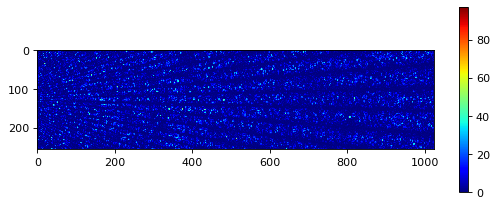

In [20]:
N = 0
mean = 0  # 正态分布的均值
stddev = N  # 正态分布的标准差
noise = np.random.normal(mean, stddev, DG.shape)
RG = RG + noise
DG = DG + noise

RG = np.round(RG)
DG = np.round(DG)
RG = np.clip(RG, 0, 255)
DG = np.clip(DG, 0, 255)

plt.figure(figsize=(8, 3), dpi=80)
plt.imshow(np.abs(RG-DG), cmap='jet', interpolation='nearest')
plt.colorbar()

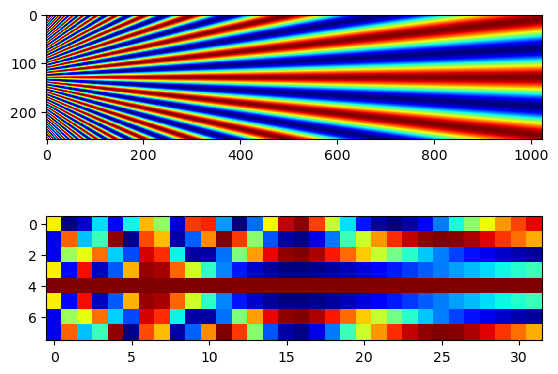

In [37]:
H, L = RG.shape;
x = np.arange(L)
y = np.arange(H)
X, Y = np.meshgrid(x, y)
pmax=120; pmin=10;  # 控制最左端的条纹数目 和 最右端的条纹数目
pwave=pmin+X*(pmax-pmin)/L
v1 = 0.5*np.cos((Y-H/2)*2*np.pi/(pwave))
# 计算矩阵的最小值和最大值
min_val = np.min(v1)
max_val = np.max(v1)
# 归一化矩阵到[-1, 1]范围
displacement_field_v = 2 * (v1 - min_val) / (max_val - min_val) - 1
displacement_field_u = np.zeros_like(RG)

step_row=32
step_col=32
u_s, _ = sample_matrix(displacement_field_u, step_row, step_col, flag=0)
v_s, _ = sample_matrix(displacement_field_v, step_row, step_col, flag=0)

# displacement_field_v[0:32, 0:128] = 0

plt.figure(dpi=100)
plt.subplot(2, 1, 1)
plt.imshow(displacement_field_v, cmap='jet', interpolation='nearest')
plt.subplot(2, 1, 2)
plt.imshow(v_s, cmap='jet', interpolation='nearest')

x_list = np.linspace(-1, 1, L)
y_list = np.linspace(-1, 1, H)
X, Y = np.meshgrid(x_list, y_list)

In [8]:
edge = 5
ROI = np.zeros_like(DG)
ROI[edge:H-edge, edge:L-edge] = 1
channels = [2, 16, 32, 64, 128]
model = PhysicsInformedNN1(RG, DG, ROI, channels, X, Y)
model.set_window(window_size=3, flag=True)
model.set_cp_dis(u_s, v_s, step_row, step_col, 100, 300)

NameError: name 'H' is not defined

In [24]:
#%% 训练阶段
pretrain_epoch = 2000
train_epoch = 2000
model_train(model, X, Y, pretrain_epoch, train_epoch, 1, 1, new_lr=0.0001)

0.008576420385033718


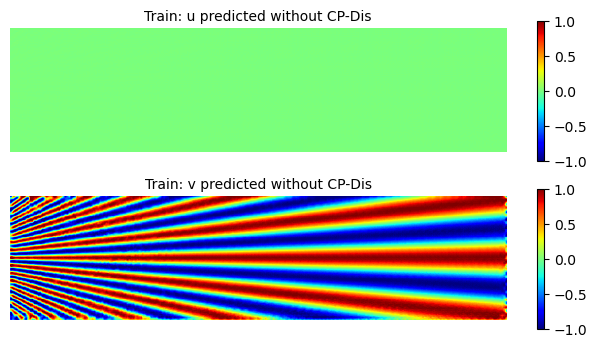

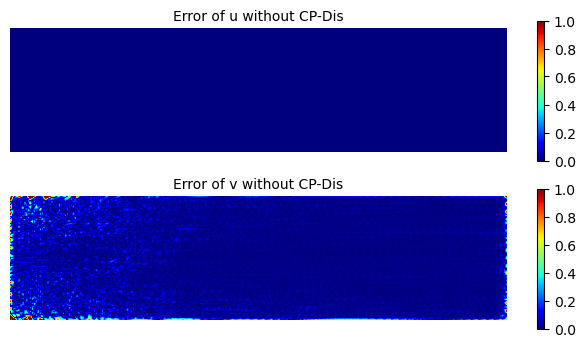

In [119]:
result_plot(model ,X, Y, -1, 1, -1, 1,' without CP-Dis', [2,1])
error_plot(model ,X, Y, displacement_field_u, displacement_field_v, 0, 1, 
           ' without CP-Dis', [2,1])

In [120]:
save_mat(model, X, Y, displacement_field_u, displacement_field_v, save_file, N, step_row, step_col, flag=True)

In [33]:
# 定义ROI区域
edge = 5
ROI = np.zeros_like(DG)
ROI[edge:H-edge, edge:L-edge] = 1

#%% 定义模型
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)
# 网络结构
channels = [2, 16, 32, 64, 128]
model = PhysicsInformedNN1(RG, DG, ROI, channels, IX, IY)
model.set_window(window_size=3, flag=True)

****************over****************
Epoch [8301], Loss: 0.4856, Loss_f: 0.4856
Epoch [8401], Loss: 0.4837, Loss_f: 0.4837
Epoch [8501], Loss: 0.7718, Loss_f: 0.7718
Epoch [8601], Loss: 0.4955, Loss_f: 0.4955
Epoch [8701], Loss: 0.5214, Loss_f: 0.5214
Epoch [8801], Loss: 0.4789, Loss_f: 0.4789
Epoch [8901], Loss: 0.7002, Loss_f: 0.7002
Epoch [9001], Loss: 0.4760, Loss_f: 0.4760
Epoch [9101], Loss: 1.4277, Loss_f: 1.4277
Epoch [9201], Loss: 0.4735, Loss_f: 0.4735
Epoch [9301], Loss: 0.5279, Loss_f: 0.5279


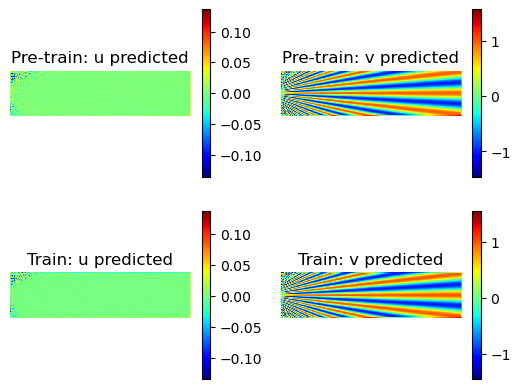

In [39]:
#%% 训练阶段
pretrain_epoch = 0
train_epoch = 1000
model_train(model, X, Y, pretrain_epoch, train_epoch, 0, 1, new_lr = 0.0001)

0.021485602926816935


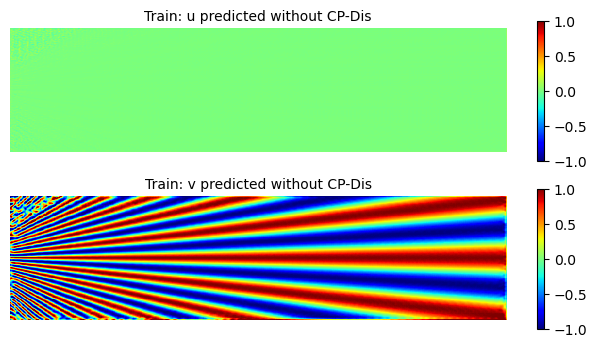

In [ ]:
result_plot(model ,X, Y, -1, 1, -1, 1,' without CP-Dis', [2,1])
error_plot(model ,X, Y, displacement_field_u, displacement_field_v, 0, 1, 
           ' without CP-Dis', [2,1])

In [12]:
save_mat(model, X, Y, displacement_field_u, displacement_field_v, save_file, N, step_row, step_col, flag=False)

In [23]:
torch.save(model.dnn.state_dict(), f'star.pth')

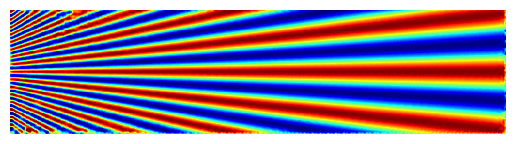

In [91]:
u1,v1 = model.predict(IX, IY)
plt.figure(dpi=100)
normv = matplotlib.colors.Normalize(vmin=-1, vmax=1)
plt.imshow(v1[0], cmap='jet', interpolation='nearest', norm=normv)
plt.axis('off')
plt.savefig('autoencoder_v.png', dpi=400)